In [1]:
# To enable autcomplete in Jupyter
%config IPCompleter.greedy=True

In [2]:
import datetime # to get current date and time
import pandas as pd
import numpy as np
from numpy.polynomial import polynomial as p
from matplotlib import pyplot as plt
from matplotlib import style as style
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
import seaborn as sns

%matplotlib inline
style.use('fivethirtyeight')

In [3]:
def pullNYTData():
    
    # Raw state csv pulled from New York Times Github
    url1 = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
    state= pd.read_csv(url1)

    # Raw county csv pulled from New York Times Github
    url2 = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
    county = pd.read_csv(url2)
    
    return state, county

In [4]:
def pullHospitalizationData():
    
    url3 = 'https://maps.arcgis.com/apps/opsdashboard/index.html#/0cc7684992b942eb81c21ff3c252c1ee'
    
    # Have to download Chromedriver, add to executable path 
    driver = webdriver.Chrome(executable_path = r'/Users/jaydenfont/Desktop/Code/Personal/Projects/jaydenfont-covid19analysis/chromedriver')
    driver.get(url3)
    
    # wait for element to load, or for timeout to occur
    timeout = 25

    # Loop until it throws an IndexError, which will occur when it tries to read where the "amcharts-balloon-div" class is not found
    # This will loop across the entire bar chart, until it reaches an element which is not a bar

    xOffset = -97 # starting offset, exactly at starting point
    hospData = []
    input("Press enter to continue")
    
    # Store path to graph
    graph = driver.find_element_by_xpath('//*[@id="ember37"]/div/div')

    while True:

        try:
            # Offset x each loop
            xOffset += 3
            
            # Navigate to bar, use context_click to see where mouse is pointing
            hover = ActionChains(driver).move_to_element(graph).move_by_offset(xOffset, 50).context_click().perform()


            # Use Javascript command to get the elements of the class containing the data
            foundBar = driver.execute_script('return document.getElementsByClassName("amcharts-balloon-div")')

            # add text to data if it is not already in list
            if hospData.count(foundBar[0].text) == 0:
                #print("offset = " + str(xOffset))
                hospData.append(foundBar[0].text)
                print(hospData[len(hospData)-1])
            else:
                break
                
        except:
            break
        
    # Close browser
    driver.quit()

    return hospData

In [5]:
def cleanNYTData(state, county):
    
    # Isolate state data for New Jersey

    # loc isolates data based on labels, save as new dataframe
    nj = state.loc[state['state'] == "New Jersey"]
    
    # Determine days of outbreak
    totalDays = nj.shape[0] # get number of rows containing NJ
    njLength = np.linspace(1,totalDays,totalDays) # create array of same length as total days of data
    njCases = np.array(nj["cases"])
    
    # Get last date of available data
    recentDate = county.at[county.index[-1], 'date']
    
    # Isolate NJ Counties for given date
    njCountyList = county[(county['state'] == "New Jersey") & (county["date"] == recentDate)]
    
    # Create list of the increase in cases between each day and rate of change
    newCases = []

    for i in range(0, len(njCases)-1):
        newCases.append(njCases[i+1]-njCases[i]) # subtract current number of cases by previous number

    newCases = np.array(newCases) # convert case number list to array
    numDaysExceptLast = len(njLength) # need to remove last day from list
    newCaseDays = np.arange(1, numDaysExceptLast) # convert day list to array
    
    # Display Data
    print("Total Cases: " + str(njCases))
    print(njCountyList)
    
    return njLength, njCases, recentDate, njCountyList, newCases, newCaseDays

In [6]:
def cleanHospitalizationData(hospData):
    
    # Clean for hospitalizations and by finding the colon, and slicing the string
    # print(hospData)
    
    dates = []
    for vals in range(len(hospData)):
        for char in hospData[vals]:
            if char == ":":
                x = hospData[vals].index(char) # get index of colon
                dates.append(hospData[vals][0:x]) # add dates to separate list
                hospData[vals] = hospData[vals][x+1:] # splice for everything after colon
        firstDigit = hospData[vals][0] # get first digit
        hospData[vals] = int(firstDigit + hospData[vals][2:]) # save number without colon as int

    # print(dates)
    # print(hospData)
    
    return hospData, dates

In [7]:
# Not used anymore
def cleanTwitterData(tweets):
    
    # convert tweet data to pandas dataframe
    tweetData = pd.DataFrame(t.__dict__ for t in tweets)
    
    # Isolate all tweets from the GovMurphy account
    tweetData = tweetData.loc[tweetData['username'] == "Governor Phil Murphy"]

    # sort from earliest to most recent
    tweetData = tweetData.sort_values(by=['timestamp_epochs']) # timestamp_epochs store number that increases with each tweet

    # reset indices of all dataframe values after sorting
    tweetText = tweetData.reset_index()

    # isolate text from each tweet into a dataframe
    tweetText = tweetText['text']
    
    # generate list of rows from dataframe, tells how many tweets there are to search
    hospDayCount = [i for i in range(tweetData.shape[0])]

    # return hospitalization numbers from all tweets, passing tweet dataframe and range of all tweets
    hospitalized = [hospitalizationExtraction(tweetText,i) for i in hospDayCount]


    # remove none values from invalid tweets
    hospitalized = [i for i in hospitalized if i != None]

    # adjust count to only include valid tweets
    hospDayCount = [i for i in range(1, len(hospitalized)+1)]
    
    print("Total Hospitalized Each Day: " + str(hospitalized))
    
    return hospDayCount, hospitalized

In [8]:
def currentTime():
    
    # Get current date and time
    
    # now method returns date and time
    now = datetime.datetime.now()
    # I returns hour in 12 hour format, p returns AM or PM based on time
    dateAndTime = now.strftime("%m/%d/%Y %I:%M %p")
    
    return dateAndTime

In [9]:
def plotTotalCases(njLength, njCases, recentDate, njCountyList, dateAndTime):
    
    # Create figure object with two subplots oriented horizontally
    figure, (sc, ba) = plt.subplots(1,2, figsize=(21,7))

    # Plot NJ cases vs time
    sc.scatter(njLength, njCases)
    sTitle = "Cases of COVID-19 in New Jersey\n(accurate as of " + recentDate + ")"
    sc.set_title(sTitle)
    sc.set_xlabel("Day of Outbreak")
    sc.set_ylabel("Number of Cases")

    # Fit curve to data 
    coefficients = p.polyfit(njLength, njCases, njLength.shape[0]);
    fit = p.polyval(njLength,coefficients);
    sc.plot(njLength, fit, color='r', linewidth=2);

    # adjust ticks to show all days
    xticks = np.arange(1,njLength.max()+1,4)
    sc.set_xticks(xticks); # semicolon suppresses output of this function

    # Create box label
    labelText = "Current number of cases = " + str(njCases.max())
    box = dict(boxstyle = 'round', facecolor = 'white') # patch options
    sc.text(5, 100000,labelText,bbox=box);

    # Plot cases per county
    ba.bar(njCountyList['county'], njCountyList['cases'] )
    bTitle = "Cases per County\n(accurate as of " + recentDate + ")"
    ba.set_xticklabels(njCountyList['county'], rotation = 90);
    ba.set_title(bTitle);
    
    print("last updated at: {}".format(dateAndTime))
    
    figure.savefig('njTotalCasesAndCounty.png', bbox_inches='tight')
    

In [10]:
def plotNewCases(newCases, newCaseDays, recentDate):
    
    # Plot daily increase
    ticks = np.arange(1,newCaseDays.max()+1,5); #generate x ticks
    fig= plt.figure(figsize=(10,4)) # create figure
    axes = fig.add_subplot() # automatically adds axis (graph) in default position
    axes.bar(newCaseDays, newCases.transpose())
    axes.set_title("Daily Increase in Cases in New Jersey and 7-Day Rolling Average Increase\n(accurate as of "
                   + recentDate + ")");
    axes.set_xticks(ticks);
    axes.set_xlabel("Day of Outbreak");
    axes.set_ylabel("Cases");

    '''
    Adding line tracing 7 day rolling average increase in cases

    Because data can be unreliable at any given day, a rolling average allows for 
    visualization of trends over a longer period of time, which is more reliable.

    At each day in the tracker, the mean is taken of the daily increases over the previous 6 days. 
    For days 1-6, there are not 6 days worth of data, so the average is taken with all days up until that point.
    After day 6, the starting variable increases by 1 to trail 6 days behind the current day's data, leaving 7 days in
    between to calculate the average.
    '''
    meanCaseIncrease = []

    sevenDayStart = 0
    for i in range(len(newCases)):
        if i > 6: # trail by 6 days once 6 days of data are available, so average of 7 days can be taken
            sevenDayStart+=1
        # mean of previous 6 days, i+1 to avoid taking mean of empty space after last day of data
        meanCaseIncrease.append(np.mean(newCases[sevenDayStart:i+1])); 

    plt.plot(newCaseDays, meanCaseIncrease, color = 'r');
    
    fig.savefig('njNewCases.png', bbox_inches='tight')

In [11]:
def plotTrajectory(newCases, newCaseDays):
    
    # Calculate 7 day rolling average and trajectory x axis
    rolling = []
    sevenDayStart = 0
    for i in newCases:
        if i > 6:
            sevenDayStart+=1
        mean = np.mean(newCases[sevenDayStart:i+1])
        if mean > 10:
            rolling.append(mean)
            
    trajectoryDates = np.linspace(1, len(rolling), len(rolling))
      
    # Curve fit of mean cases
    coeff = p.polyfit(trajectoryDates, rolling, newCaseDays.shape[0])
    fit = p.polyval(trajectoryDates, coeff)
    
    # Plot mean new cases in logarithmic scale
    ticks = np.arange(1,trajectoryDates.max()+1, 5); #generate y ticks
    figure = plt.figure()
    traj = figure.add_subplot()
    traj.plot(trajectoryDates, fit, linewidth=2, color='r')
    traj.scatter(trajectoryDates, rolling)
    traj.set_yticks(ticks)
    traj.set_yscale('log')
    traj.set_xlabel("Days Available")
    traj.set_ylabel("New Cases")
    traj.set_title("Trajectory of Newly Reported Cases (7 Day Rolling Average)")
    
    figure.savefig('njTrajectory.png',bbox_inches='tight')

In [12]:
# Not used anymore
def hospitalizationExtraction(dataframe, indexOfTweet):

    """
    Parses tweet for the number of hospitalized patients.
    
    Given a dataframe and the index of the tweet in the dataframe, finds where the word 'hospitalized'
    is in that tweet. Then it loops in reverse from that word to the beginning of the tweet until it finds a "word"
    which is a numerical value (the closest number before "hospitalizations" will be the probably be number of 
    hospitalized people, since that is how the sentences are written).
    However, if the first numerical characters are not the correct number, it will keep looking until it finds it.
    It then stores each character of the number in a list, then joins to string, then returns as int
    """
    
    wordsInTweet = dataframe[indexOfTweet].split() # split tweet into list of words
    
    # find index of "hospitalized", trying different splits with punctuation
    
    try:
        hospFound = wordsInTweet.index("hospitalized") # find 'hospitalized'
    except ValueError:
        try: 
            hospFound = wordsInTweet.index("hospitalized.") # find 'hospitalized.''
        except ValueError:
            try: 
                hospFound = wordsInTweet.index("hospitalized,") # find 'hospitalized.' 
            except ValueError:
                try: 
                    hospFound = wordsInTweet.index("hospitals") # find 'hospitals' 
                except:
                    try: 
                        hospFound = wordsInTweet.index("hospitals.") # find 'hospitals.' 
                    except:
                        try:
                            hospFound = wordsInTweet.index("hospitalizations")
                        except:
                            return
    
    # loop from "hospitalizations" to the beginning of the list until the correct number is found

    digits = [] # holds list of all digits in the number
    
    for word in range(hospFound,-1,-1): # loop through words (from -1 to include 0) 
        for char in wordsInTweet[word]: 
            if char.isdigit() or char == "0": 
                digits.append(char)
            elif char == ":": # prevents times in XX:XX format or twitter URLs from being included
                digits = []
          
        # if the number has 3 or more digits, and the first digit is 3, it is most likely correct, so break loop
        if len(digits) > 3 and len(digits) < 5 and int(digits[0]) > 2: 
            break
        # if the number is 2 digits or less, it is probably wrong so disregard these and continue loop
        else: 
            digits = []
      
    # if the number isn't before the word "hospitalizations" (or others from above), search all words after it
    if len(digits) == 0:
        
        for word in range(hospFound, len(wordsInTweet)):
            for char in wordsInTweet[word]: 
                if char.isdigit() or char == "0": 
                    digits.append(char)
                elif char == ":" or char.isalpha():
                    digits = []

            if len(digits) > 3 and len(digits) < 5 and int(digits[0]) > 2: 
                break
         
            else: 
                digits = []
     
    number = ""
    try:
        number = int(number.join(digits)) # combine digits into one string and convert to int
        '''
        print("Unit test:")
        print(dataframe[indexOfTweet])
        print("NUMBER RETURNED = " + str(number))
        print("------------------------------------------------------------------------")
        '''
        return number
    except:
        return None # if the tweet is not in the proper format (no valid numbers or otherwise), return none


In [13]:
# not used anymore
def plotHospitalizationsOld(hospDayCount, hospitalized):
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.bar(hospDayCount,hospitalized)
    ax.set_title("Total Hospitalized per Day in New Jersey\n(accurate as of {})".format(datetime.date.today()))
    ax.set_ylabel('Hospitalized Individuals')
    ax.set_xlabel('Days Reported')
    ax.set_xticks(hospDayCount);
    ax.text(np.percentile(hospDayCount,25), np.min(hospitalized)-6000,"(Sourced from @GovMurphy on Twitter)"); # place text box at 1st quartile of dates

    def percentChangeHospitalizations(hospitalized):
        # Calculates percentage change in hospitalizations over last 7 days
        mostRecent = len(hospitalized)-1
        totalDecrease = hospitalized[mostRecent] - hospitalized[mostRecent-7]
        pctDecrease = round((totalDecrease / hospitalized[mostRecent-7]) * 100, 2)
        return str(pctDecrease) + "%"

    pct = dict(boxstyle = 'round', facecolor = 'white')
    text = percentChangeHospitalizations(hospitalized) + " change over last 7 days"
    ax.text(8, max(hospitalized) ,text,bbox=pct);


In [14]:
def plotHospitalizations(dates, hospData):
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.bar(dates, hospData)
    ax.set_title("Total Hospitalized per Day in New Jersey\n(accurate as of {})".format(datetime.date.today()))
    ax.set_ylabel('Hospitalized Individuals')
    ax.set_xlabel('Days Reported')
    frequency = 7
    ax.set_xticks(dates[::frequency])
    ax.tick_params(labelrotation=70)
    
    def percentChangeHospitalizations(hospitalized):
        # Calculates percentage change in hospitalizations over last 7 days
        mostRecent = len(hospData)-1
        totalDecrease = hospData[mostRecent] - hospData[mostRecent-7]
        pctDecrease = round((totalDecrease / hospData[mostRecent-7]) * 100, 2)
        return str(pctDecrease) + "%"

    pct = dict(boxstyle = 'round', facecolor = 'white')
    text = percentChangeHospitalizations(hospData) + " change over last 7 days"
    ax.text(21, max(hospData)-1000,text,bbox=pct);
    
    fig.savefig('njHospitalizations.png',bbox_inches='tight')

Press enter to continue
4/4/20:6,387
4/6/20:7,042
4/7/20:7,247
4/8/20:7,481
4/9/20:7,609
4/10/20:7,653
4/12/20:7,789
4/13/20:8,001
4/14/20:8,065
4/15/20:7,966
4/16/20:7,742
4/18/20:7,369
4/19/20:7,287
4/20/20:7,443
4/21/20:7,328
4/22/20:7,195
4/24/20:6,741
4/25/20:6,585
4/26/20:6,446
4/27/20:6,468
4/28/20:6,282
4/30/20:5,892
5/1/20:5,643
5/2/20:5,490
5/3/20:5,330
5/4/20:5,284
5/6/20:4,938
5/7/20:4,736
5/8/20:4,559
5/9/20:4,273
5/10/20:4,181
5/12/20:4,156
5/13/20:3,885
5/14/20:3,740
5/15/20:3,495
5/16/20:3,439
5/18/20:3,413
5/19/20:3,351
5/20/20:3,152
5/21/20:3,020
5/22/20:2,929
5/23/20:2,865
5/25/20:2,679
5/26/20:2,719
5/27/20:2,753
5/28/20:2,643
5/29/20:2,522
5/31/20:2,336
6/1/20:2,344
6/2/20:2,207
6/3/20:1,966
6/4/20:1,914
6/6/20:1,744
6/7/20:1,681
6/8/20:1,706
6/9/20:1,666
6/10/20:1,462
6/12/20:1,355
6/13/20:1,361
6/14/20:1,281
6/15/20:1,240
6/16/20:1,325
6/18/20:1,193
6/19/20:1,140
6/20/20:1,128
6/21/20:1,048
6/22/20:1,092
6/24/20:1,183
6/25/20:1,118
6/26/20:1,103
6/27/20:1,027
6/2

/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py:706: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polynomial.py:1336: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polyutils.py:706: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))
/opt/an

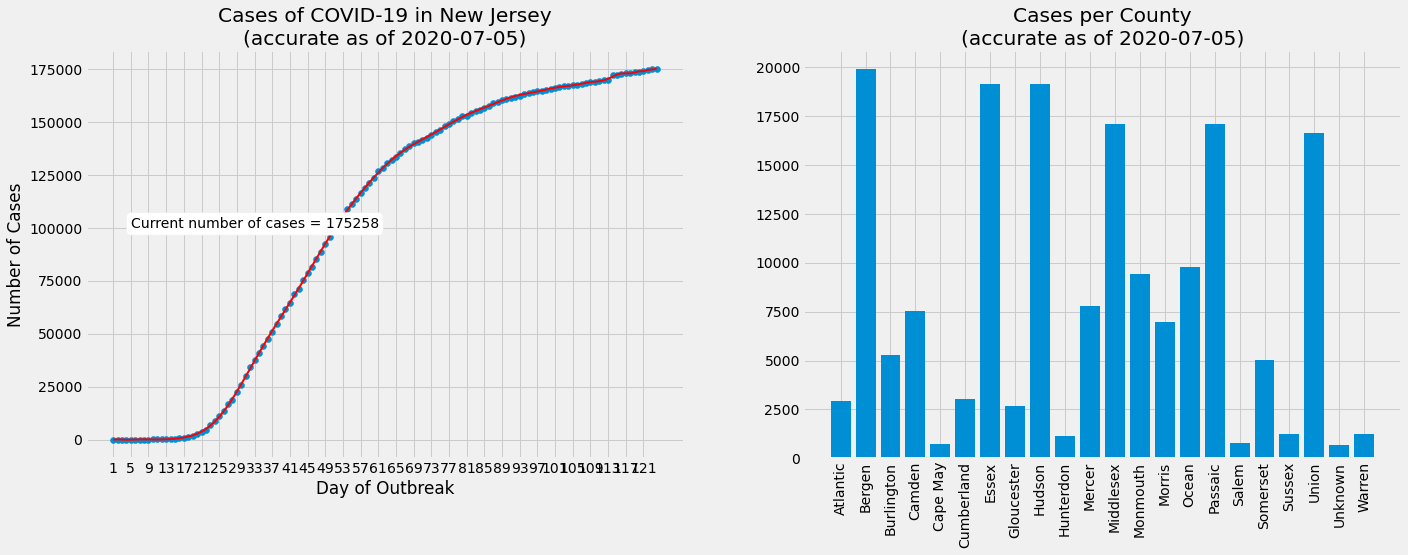

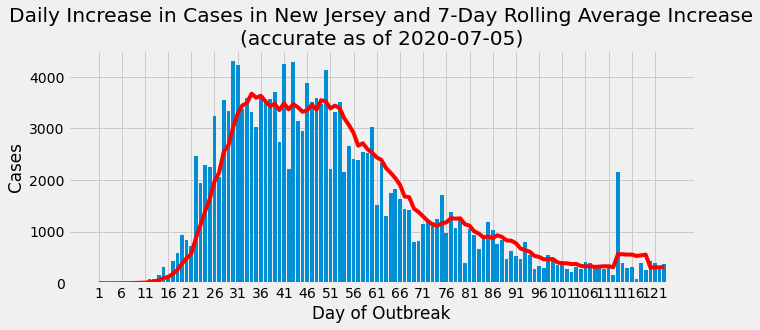

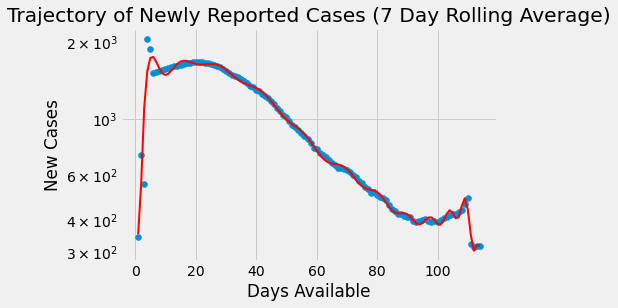

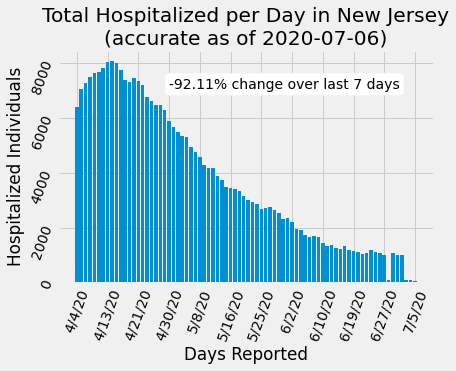

In [15]:
def main():
    dateAndTime = currentTime()
    [state, county] = pullNYTData()
    hospData = pullHospitalizationData()
    [njLength, njCases, recentDate, njCountyList, newCases, newCaseDays] = cleanNYTData(state, county)
    [hospData, dates] = cleanHospitalizationData(hospData)
    plotTotalCases(njLength, njCases, recentDate, njCountyList, dateAndTime)
    plotNewCases(newCases, newCaseDays, recentDate)
    plotTrajectory(newCases, newCaseDays)
    plotHospitalizations(dates, hospData)
    
    # return all data for testing in next cell if needed
    return dates, hospData, njLength, njCases, recentDate, njCountyList, dateAndTime, newCases, newCaseDays, state, county

if __name__ == "__main__":
    [dates, hospData, njLength, njCases, recentDate, njCountyList, dateAndTime, newCases, newCaseDays, state, county] = main()